<a href="https://colab.research.google.com/github/adrianoracano/Prog-NAPDE/blob/main/prova_cn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [12]:
%cd /gdrive/My Drive

/gdrive/My Drive


In [13]:
!git clone https://github.com/adrianoracano/Prog-NAPDE.git

fatal: destination path 'Prog-NAPDE' already exists and is not an empty directory.


In [14]:
%cd /gdrive/My Drive/Prog-NAPDE

/gdrive/My Drive/Prog-NAPDE


In [15]:
import numpy as np
import tensorflow as tf
import math
import MyCrankNicolsonClass as cnc
from matplotlib import pyplot as plt

np.random.seed(123)
tf.random.set_seed(123)

## ODE-NN


In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(123)
tf.random.set_seed(123)

In [17]:
# initial condition
f0 = 1
# infinitesimal small number
inf_s = np.sqrt(np.finfo(np.float32).eps)

# Parameters
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = training_steps/10

# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons

weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_output]))
}

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [18]:
# Create model
def multilayer_perceptron(x):
    x = np.array([[[x]]],  dtype='float32')
    # Hidden fully connected layer with 32 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    # Hidden fully connected layer with 32 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    # Output fully connected layer
    output = tf.matmul(layer_2, weights['out']) + biases['out']
    return output

# Universal Approximator
def g(x):
    return x * multilayer_perceptron(x) + f0

# Given EDO
def f(x):
    return 2*x
    
# Custom loss function to approximate the derivatives
def custom_loss():
    summation = []
    for x in np.linspace(0,1,10):
        dNN = (g(x+inf_s)-g(x))/inf_s
        summation.append((dNN - f(x))**2)
    return tf.reduce_sum(tf.abs(summation))

In [19]:
def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [10]:
for i in range(training_steps):
    train_step()
    if i % display_step == 0:
        print("loss: %f " % (custom_loss()))

loss: 4216.851074 
loss: 4.348598 
loss: 4.212492 
loss: 4.128182 
loss: 4.046163 
loss: 3.928887 
loss: 3.629016 
loss: 1.611184 
loss: 0.089094 
loss: 0.018557 


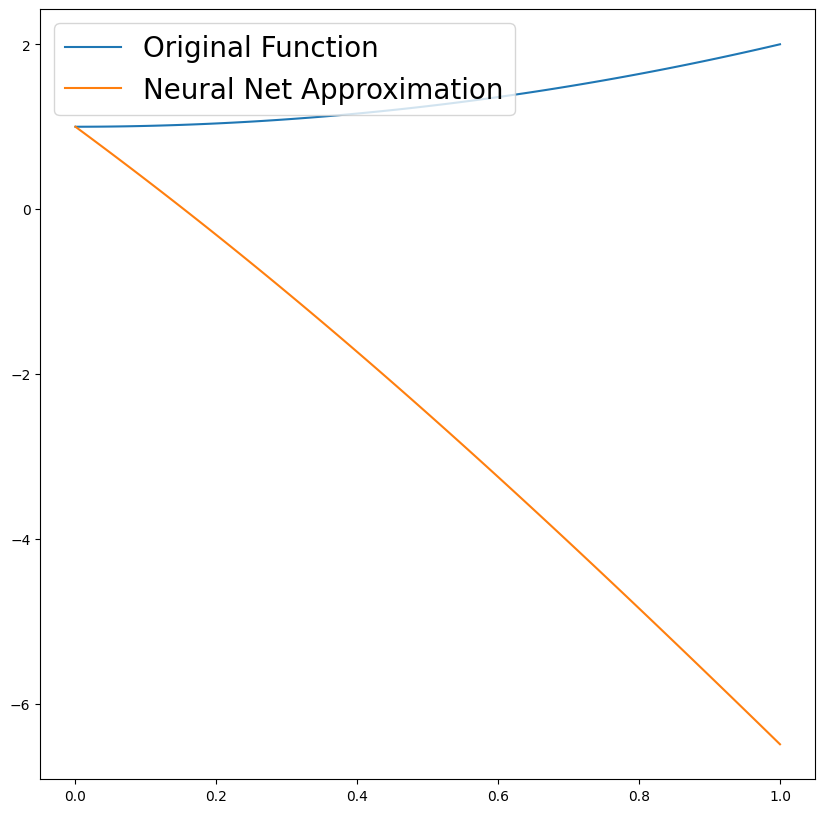

In [20]:
from matplotlib.pyplot import figure

figure(figsize=(10,10))
# True Solution (found analitically)
def true_solution(x):
    return x**2 + 1

X = np.linspace(0, 1, 100)
result = []
for i in X:
  # result.append(f(i))
  result.append(g(i).numpy()[0][0][0])

S = true_solution(X)
  
plt.plot(X, S, label="Original Function")
plt.plot(X, result, label="Neural Net Approximation")
plt.legend(loc=2, prop={'size': 20})
plt.show()

##Mia prova


In [91]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers

In [93]:
x = multilayer_perceptron(2)
x

<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[1.5805148]]], dtype=float32)>

In [101]:
input_shape = (1,)

In [102]:
#def build_ffnn(input_shape):

# Build the neural network layer by layer
input_layer = tfkl.Input(shape=(input_shape), name='Input')
hidden_layer1 = tfkl.Dense(units=64, activation='relu', name='Hidden1')(input_layer)
hidden_layer2 = tfkl.Dense(units=64, activation='relu', name='Hidden2')(hidden_layer1)
output_layer = tfkl.Dense(units=1, activation='linear', name='Output')(hidden_layer2)

# Connect input and output through the Model class
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='FFNN')

x = np.array([[2]])
y = model(x)[0]
print(y)
print(y*y)
    # Return the model
    #return model

tf.Tensor([-0.0664582], shape=(1,), dtype=float32)
tf.Tensor([0.00441669], shape=(1,), dtype=float32)


In [104]:
def g2(x):
  #x is a scalar
  x = np.array([[x]])
  return x * model(x) + f0
def custom_loss2():
  summation = []
  for x in np.linspace(-1,1,10):
    dNN = (g2(x+inf_s)-g2(x))/inf_s
    summation.append((dNN - f(x))**2)
    return tf.sqrt(tf.reduce_mean(tf.abs(summation)))
    # Compile the model
loss = custom_loss2()
optimizer = tfk.optimizers.SGD(learning_rate)
model.compile(loss=loss, optimizer=optimizer)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.06629127]], dtype=float32)>

In [107]:
model

AttributeError: ignored

In [ ]:
model.fit(epochs = 100)

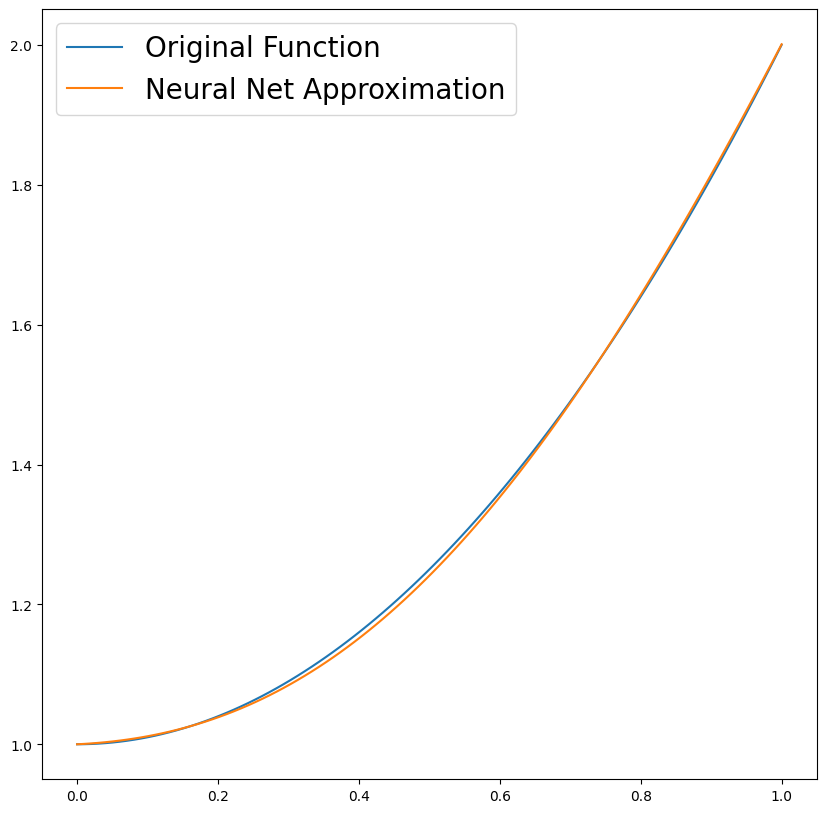

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10,10))
# True Solution (found analitically)
def true_solution(x):
    return x**2 + 1

X = np.linspace(0, 1, 100)
result = []
for i in X:
  # result.append(f(i))
  result.append(g(i).numpy()[0][0][0])

S = true_solution(X)
  
plt.plot(X, S, label="Original Function")
plt.plot(X, result, label="Neural Net Approximation")
plt.legend(loc=2, prop={'size': 20})
plt.show()

## Prova

loss: 0.021361 
loss: 0.020949 
loss: 0.020536 
loss: 0.020125 
loss: 0.019713 
loss: 0.019302 
loss: 0.018892 
loss: 0.018481 
loss: 0.018072 
loss: 0.017662 


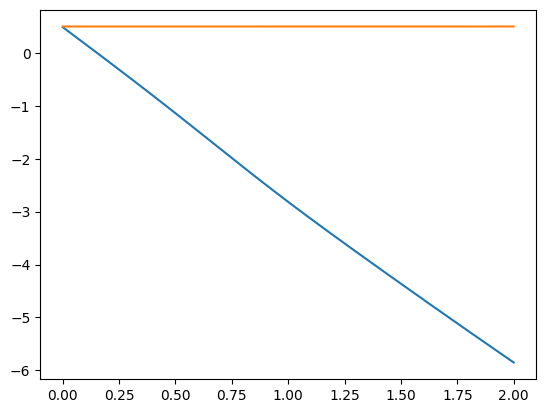

In [7]:
f0 = 1
inf_s = np.sqrt(np.finfo(np.float32).eps)
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = 50
# Network Parameters
n_input = 2     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 32 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons
weights = {
'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
'b1': tf.Variable(tf.random.normal([n_hidden_1])),
'b2': tf.Variable(tf.random.normal([n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_output]))
}
# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Create model
def multilayer_perceptron(x):
  x = np.array([[[x]]],  dtype='float32')
  layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
  layer_1 = tf.nn.sigmoid(layer_1)
  layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
  layer_2 = tf.nn.sigmoid(layer_2)
  output = tf.matmul(layer_2, weights['out']) + biases['out']
  return output
# Universal Approximator
def g(beta, T):
    x = np.array([beta, T])
    #return x * multilayer_perceptron(x)
    return multilayer_perceptron(x)
# Given EDO
tau = 365.

def beta_eq(T):
    return 1.0 - T

def T(t):
    return math.cos(t)

def dbeta(beta, t):
    return 1/tau*( beta_eq(T(t)) - beta[0] )
def dbeta_hat(beta, t):
    return g(beta[0], T(t))
    
sys = [dbeta]    

def f(x):
  return 2*x
# Custom loss function to approximate the derivatives
"""
def custom_loss():
  summation = []
  t_max=1.0
  N=50
  beta0=np.array([0.5])
  cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
  cn_solver.compute_solution()
  t, beta = cn_solver.get_solution()
  sys_hat=[dbeta_hat]
  cn_solver_hat = cnc.CrankNicolson(sys_hat, beta0, t_max, N)
  cn_solver_hat.compute_solution()
  t, beta_hat = cn_solver_hat.get_solution()
  for i in range(len(beta)):
      summation.append( ( beta[i] - beta_hat[i] )**2 )
  return tf.sqrt(tf.reduce_mean(tf.abs(summation)))
"""

t_max=2.0
N=500
beta0=np.array([0.5])
cn_solver = cnc.CrankNicolson(sys, beta0, t_max, N)
cn_solver.compute_solution()
t, beta = cn_solver.get_solution()
dt = t_max /N


def custom_loss():
    
    curr_beta = beta0[0]
    next_beta = curr_beta
    summation = []
    for i in range(len(beta)):
        x = np.array([curr_beta, T(i*dt)])
        next_beta = curr_beta + dt * multilayer_perceptron( x )
        summation.append( dt*(beta[i] - next_beta)**2 )
        curr_beta = next_beta
    return tf.sqrt(tf.reduce_sum(tf.abs(summation)))

def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables=list(weights.values())+list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
# Training the Model:
for i in range(training_steps):
  train_step()
  if i % display_step == 0:
    print("loss: %f " % (custom_loss()))

summation = [beta0[0]]
curr_beta = beta0[0]
beta_hat = np.zeros(beta.shape[1])
for i in range(beta.shape[1]):
    # x = np.array([curr_beta, T(i*dt)])
    # print(curr_beta)
    next_beta = curr_beta + dt * g( curr_beta, T(dt*i) ).numpy()[0][0][0][0]
    beta_hat[i] = next_beta
    curr_beta = next_beta
    
plt.plot(t, beta_hat)

cn_solver.plot_solutions("soluzione vera")
